In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kr_helper_funcs as kr
from sklearn.preprocessing import MinMaxScaler
import kr_helper_funcs as kr
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from lime import lime_tabular
import shap
import tensorflow_addons as tfa
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# New Model - this is trained using only continous values and the zip_code (the bias) is removed

In [2]:
name = 'without_postcode'
fileName = "{}/lending-club-values.csv".format(name)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model = tf.keras.models.load_model('{}/lending-club.h5'.format(name), custom_objects={"f1": kr.f1, "optimizer": ranger})
X_train_unscaled = np.load("{}/X_train_unscaled.npy".format(name))
X_test_unscaled = np.load("{}/X_test_unscaled.npy".format(name))
y_train = np.load("{}/y_test.npy".format(name))
y_test = np.load("{}/y_test.npy".format(name))
df = pd.read_csv('{}/lending-club-df.csv'.format(name))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

prev_scaled_row = None
cached_map_values = None
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

res = pd.read_csv(fileName)

In [3]:
## Data 
# original_probability - the probability of the row before any column is changed
# new_probability - the new probability after features in the row have been replaced depending on the neutralizing strategy
# confidence_diff - difference (original_probability -new_probability) 
# original_class - the class predicted by the model using the original row
# class_change - if the new row is labelled as a different class
# no_features - represents the number of features changed inside the row (from 0 to 10 incl)
# nsamples - the number of samples the explainer can use to generate an explanation (here we only use auto)
# explainer - which explainer has been used? shap, lime, eli5, or random?
# time - time taken for the explainer
# feature_rankings - in a list with many rankings we can replace the first ones (most important), middle, or last ones (lest important)
# strategy - mean:neutralize the points using the mean average of the training set; 
#            distribution - use 20 randomly selected values equally from both classes to replace this feature, then generate a prediction for each and average the prediction
#            distribution_others: neuttralise all other features except the points that are important
#i columns represnet the feaure that has been neutralised 

In [4]:
pd.options.display.max_columns = None
res

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,strategy,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
0,0.771427,0.771427,0.000000,1,False,0,auto,shap,63.862481,first,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.771427,0.771427,0.000000,1,False,0,auto,shap,1.863258,first,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.771427,0.625639,0.145788,1,False,0,auto,shap,1.889663,first,distribution_others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.771427,0.771427,0.000000,1,False,0,auto,shap,0.265599,middle,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.771427,0.771427,0.000000,1,False,0,auto,shap,1.840083,middle,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79195,0.334269,0.449260,0.114992,0,False,10,auto,eli5,1.353525,middle,distribution,13.0,17.0,15.0,20.0,19.0,10.0,7.0,5.0,12.0,24.0,NaN
79196,0.334269,0.676450,0.342181,0,True,10,auto,eli5,1.401582,middle,distribution_others,13.0,17.0,15.0,20.0,19.0,10.0,7.0,5.0,12.0,24.0,NaN
79197,0.334269,0.346747,0.012479,0,False,10,auto,eli5,0.187468,last,mean,5.0,12.0,24.0,31.0,0.0,18.0,11.0,32.0,26.0,28.0,NaN
79198,0.334269,0.348145,0.013876,0,False,10,auto,eli5,1.268187,last,distribution,5.0,12.0,24.0,31.0,0.0,18.0,11.0,32.0,26.0,28.0,NaN


In [5]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'earliest_cr_year'],
      dtype='object')

In [6]:
df.corr()["loan_amnt"].sort_values(ascending=False)

loan_amnt                     1.000000
installment                   0.953213
term                          0.391817
annual_inc                    0.330614
revol_bal                     0.326887
verification_status           0.318876
mort_acc                      0.225478
total_acc                     0.221688
open_acc                      0.192518
sub_grade                     0.187804
home_ownership                0.176265
int_rate                      0.174386
purpose_debt_consolidation    0.108574
emp_length                    0.100202
revol_util                    0.097433
dti                           0.042188
application_type              0.023764
purpose_credit_card           0.022690
purpose_small_business        0.017957
purpose_house                 0.011926
purpose_home_improvement      0.001194
purpose_renewable_energy     -0.016777
purpose_educational          -0.022131
purpose_wedding              -0.032901
purpose_major_purchase       -0.057894
purpose_medical          

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.6460802555084229, 0.6305155158042908, 0.6274781823158264, 0.6258445382118225, 0.6246732473373413, 0.6237831115722656, 0.6234939694404602, 0.6223732233047485, 0.6225500106811523, 0.6219271421432495, 0.6216260194778442, 0.6209747195243835, 0.6203930974006653, 0.6202287673950195, 0.6191228032112122, 0.6195740699768066, 0.6192406415939331, 0.6185083389282227, 0.6183699369430542]


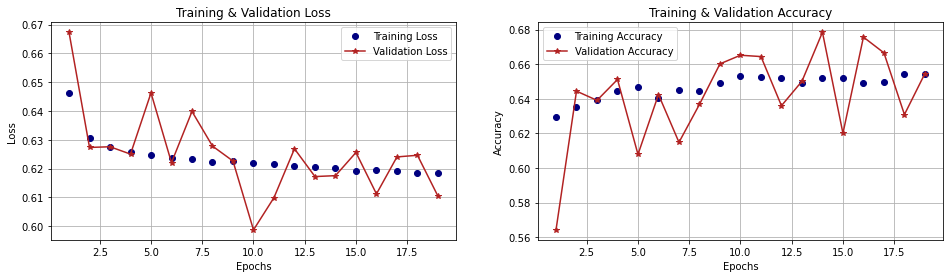

In [7]:
history = pd.read_csv('{}/lending-club-history.csv'.format(name))
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [8]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.32      0.61      0.42     14535
           1       0.88      0.69      0.78     60851

    accuracy                           0.68     75386
   macro avg       0.60      0.65      0.60     75386
weighted avg       0.78      0.68      0.71     75386



[[ 8937  5598]
 [18640 42211]]


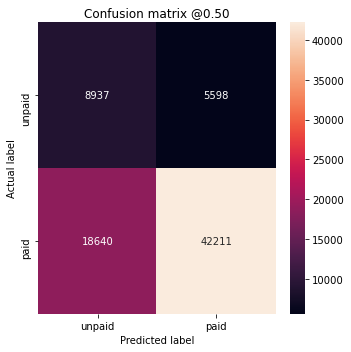

In [9]:
kr.plot_cm(y_test, predictions, ["unpaid", "paid"])

(20.0, 0.0)

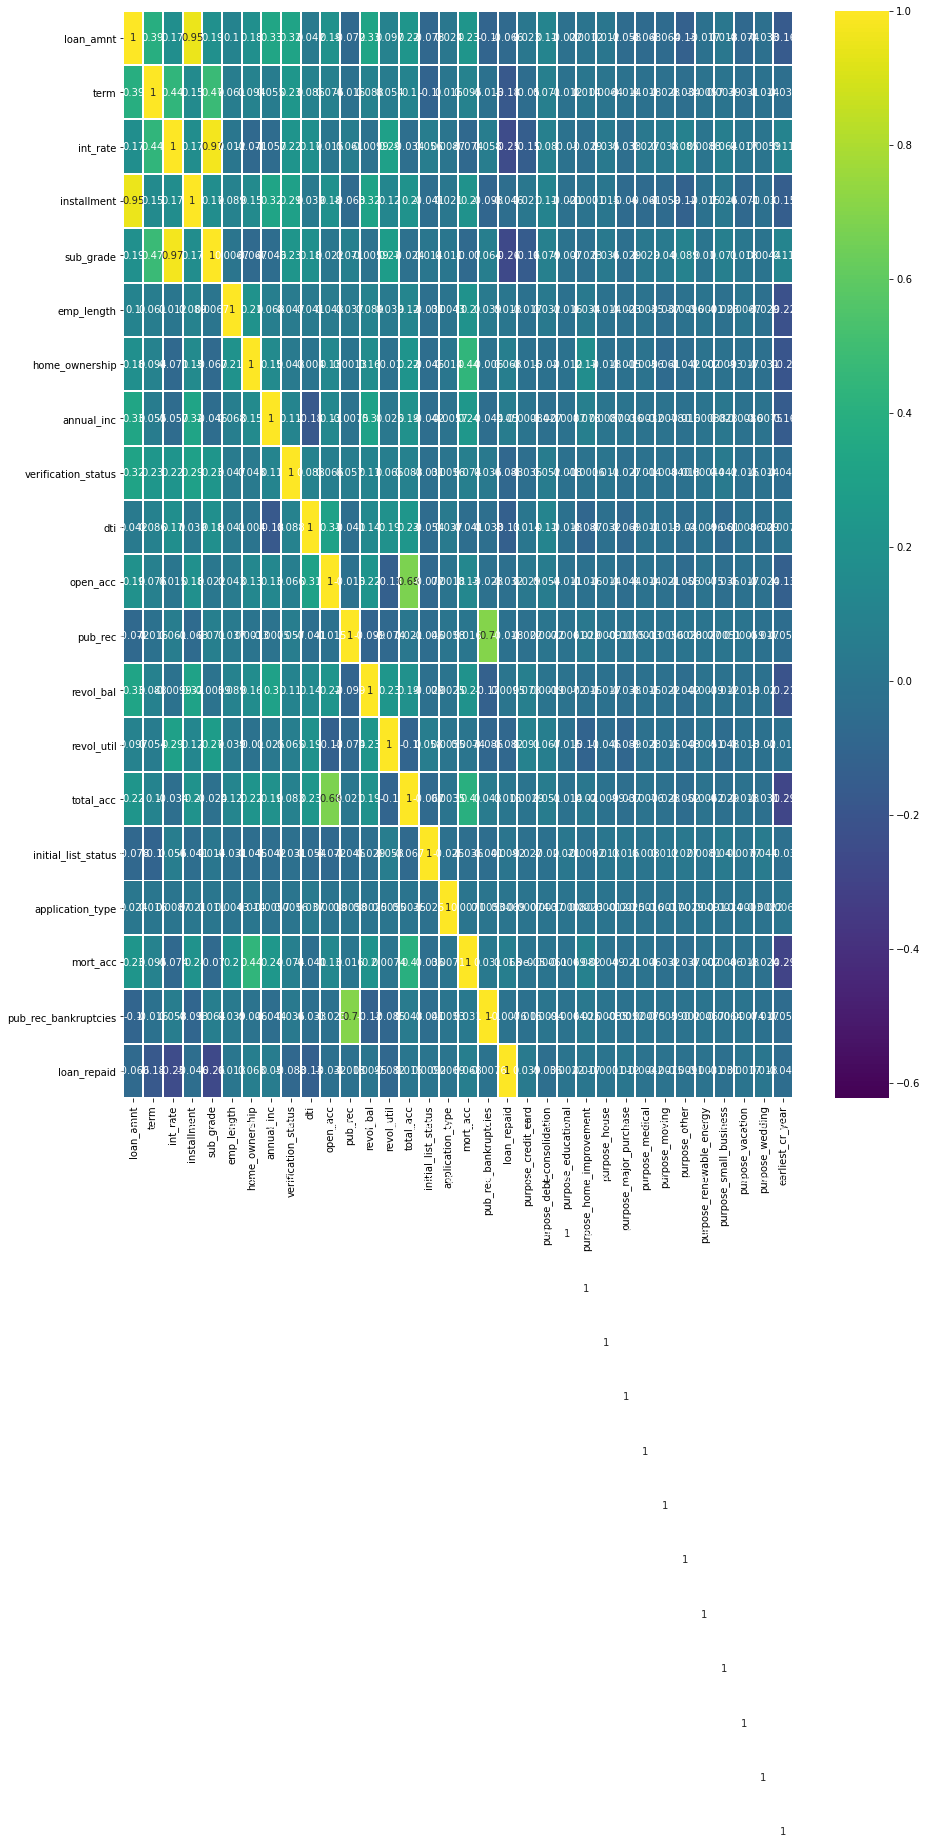

In [10]:
plt.figure(figsize=(15,20))
sns.heatmap(df.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(20, 0)


              precision    recall  f1-score   support

           0       0.32      0.61      0.42     14535
           1       0.88      0.69      0.78     60851

    accuracy                           0.68     75386
   macro avg       0.60      0.65      0.60     75386
weighted avg       0.78      0.68      0.71     75386



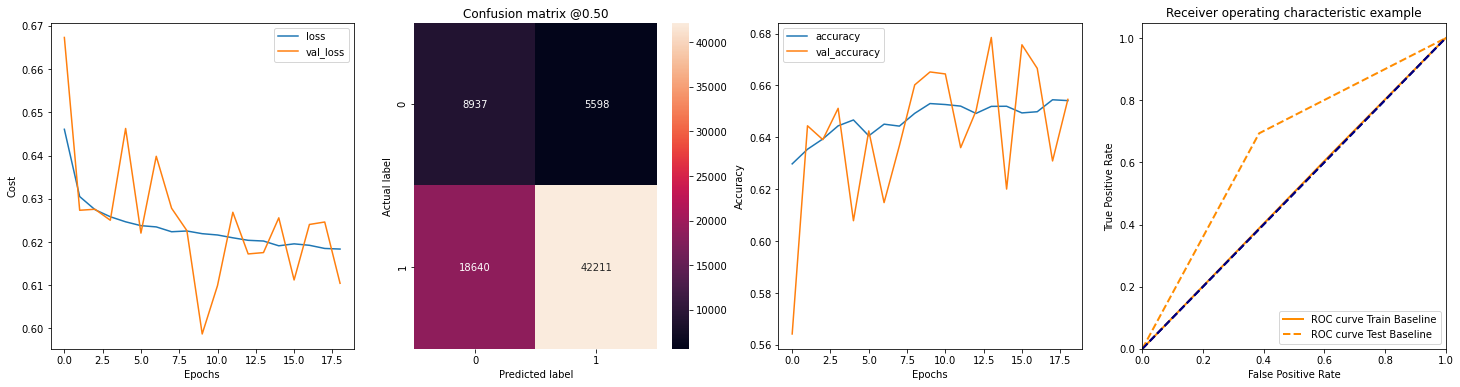

In [11]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def plot_model_results(model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
#     save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train[:len(X_test)]) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
#     save('/building_ann/' + model_name + '.png')
    plt.show()
plot_model_results(model)

In [12]:
len(X_test)

75386

In [13]:
res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random')].head()


,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,strategy,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
39600,0.771427,0.771427,0.000000,1,False,0,auto,random,0.358635,first,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39601,0.771427,0.771427,0.000000,1,False,0,auto,random,2.468471,first,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39602,0.771427,0.628800,0.142627,1,False,0,auto,random,2.588940,first,distribution_others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39603,0.771427,0.771427,0.000000,1,False,0,auto,random,0.332429,middle,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39604,0.771427,0.771427,0.000000,1,False,0,auto,random,2.702401,middle,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## G1 Number of rows from each class (50 for class 0 and 50 for class 1)

Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

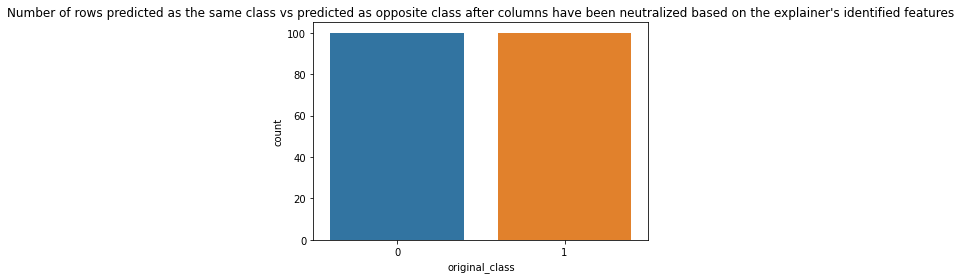

In [14]:
sns.countplot(x="original_class",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['explainer'] == 'eli5') 
                                          & (res['explainer'] == 'eli5') & (res['feature_rankings'] == 'first')  & (res['no_features'] == 0)])
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

## G2 All class changes (per class) across all explainers that occured while using strategy distribution and feature ranking first

Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

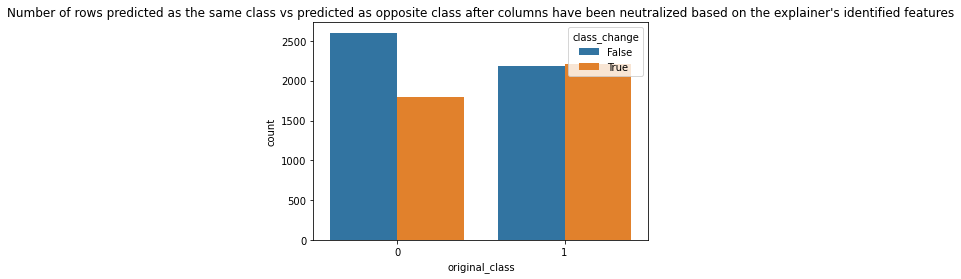

In [15]:
sns.countplot(x="original_class",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['feature_rankings'] == 'first') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

## G3 All class changes (per explainer) across both classes that occured while using strategy distribution and feature ranking first

Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

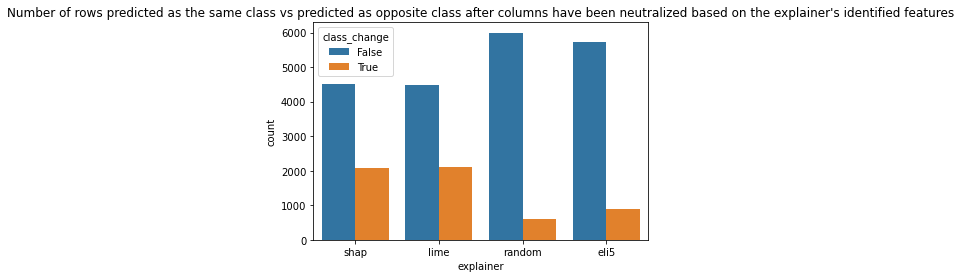

In [16]:
sns.countplot(x="explainer",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

In [17]:
res.count()

original_probability    79200
new_probability         79200
confidence_diff         79200
original_class          79200
class_change            79200
no_features             79200
nsamples                79200
explainer               79200
time                    79200
feature_rankings        79200
strategy                79200
i0                      72000
i1                      64782
i2                      57582
i3                      50382
i4                      43182
i5                      35982
i6                      28782
i7                      21582
i8                      14352
i9                       7146
i10                         0
dtype: int64

In [18]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'earliest_cr_year'],
      dtype='object')

## G4 This shows a total count for each explainer of features that appear in the i coulumns regradless of their position (importance). For eli5 the count is always the same as it always returns the same features independent of the row (this is a global feature importance). The  (res["original_class"] == 0) can be commented out for a count specific to a class

Text(0.5, 1.0, 'Random - Contplot across all feature importances')

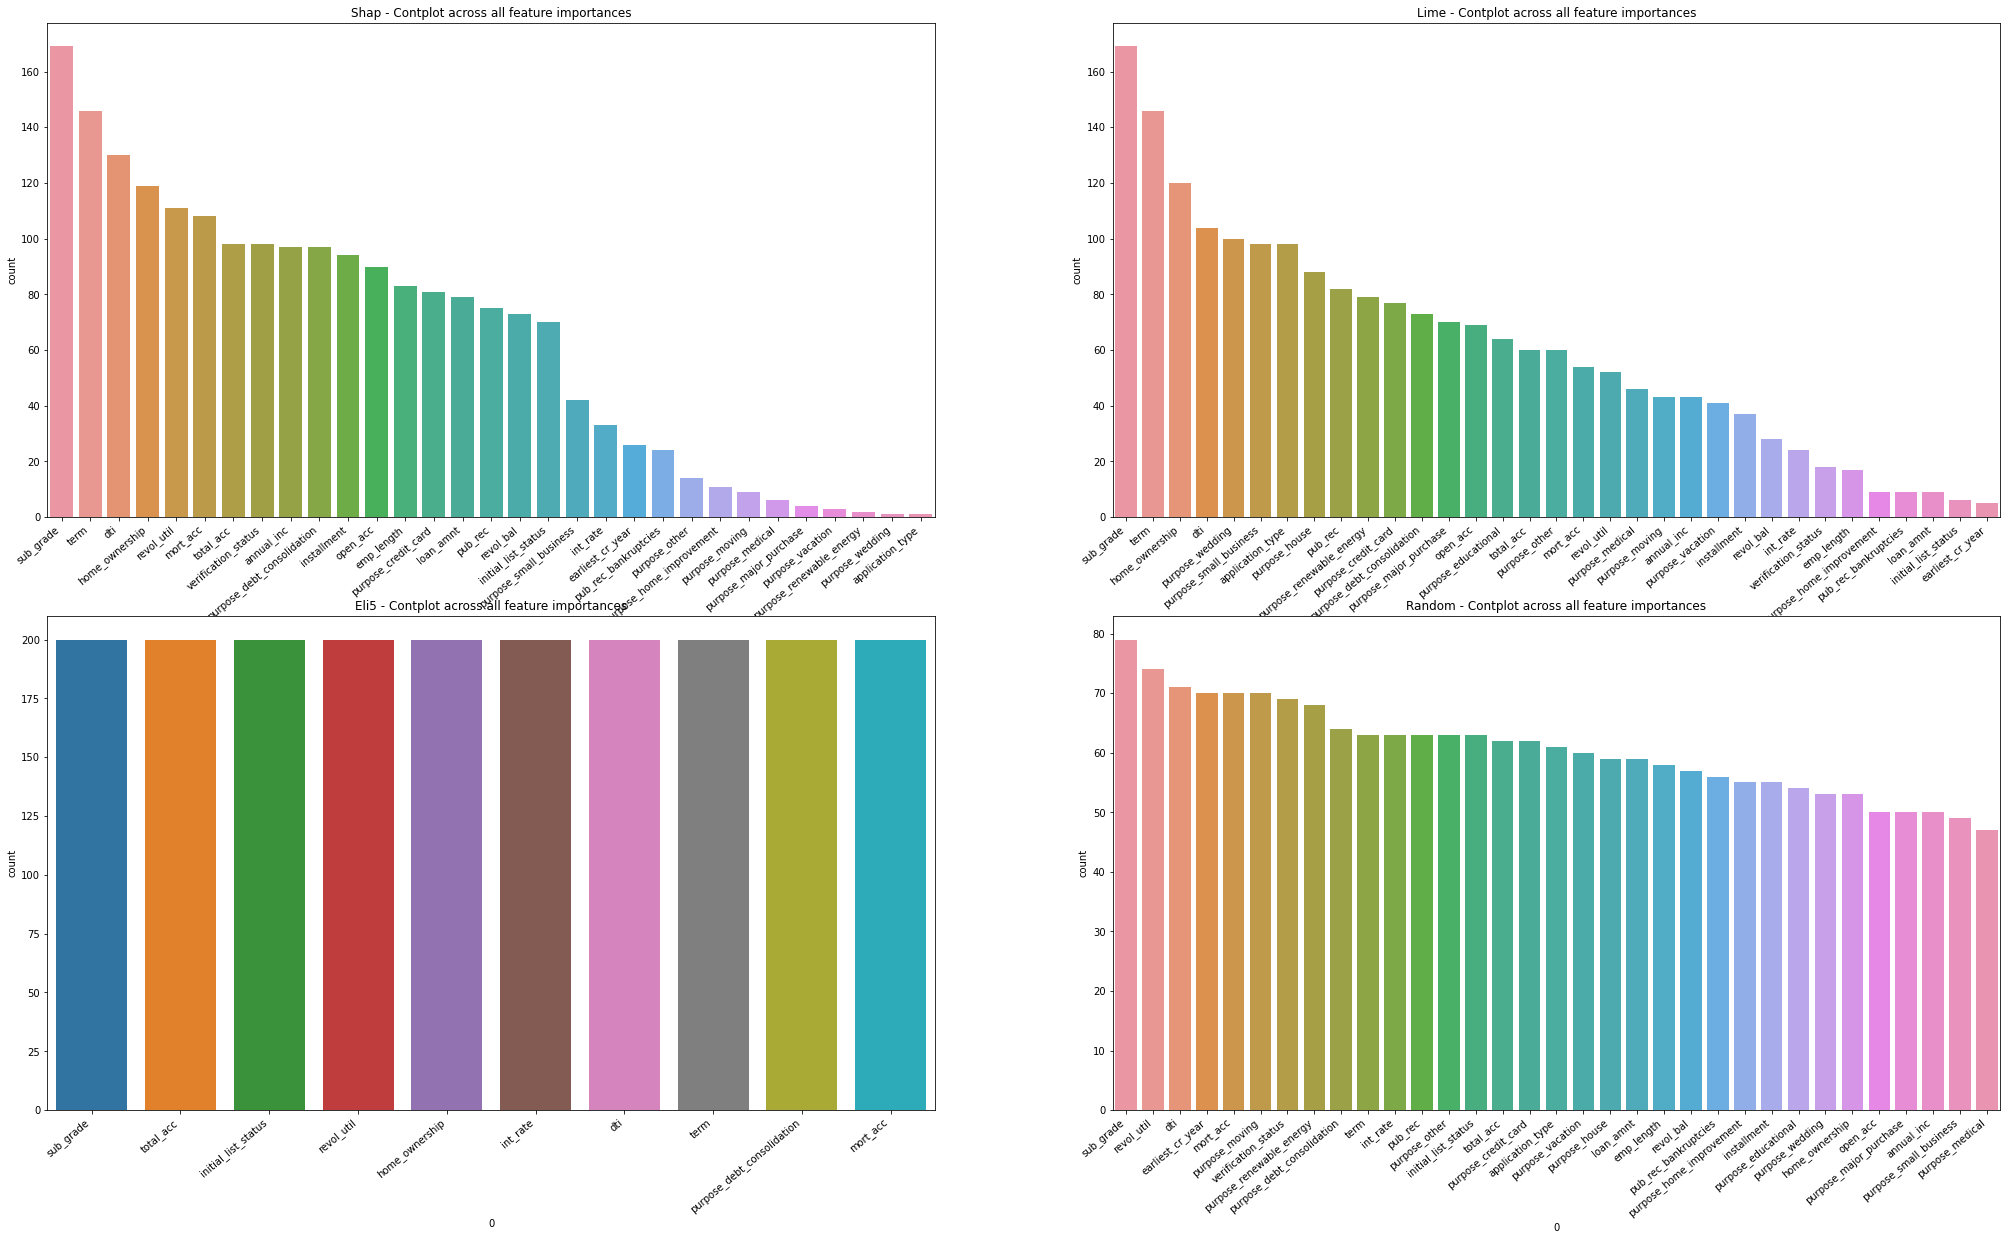

<Figure size 1800x288 with 0 Axes>

In [19]:
def get_countplot(explainer, feature_rankings="first"):
    columns = df.drop('loan_repaid', axis=1).columns
    result = res[(res['nsamples'] == 'auto') & (res['explainer'] == explainer) & (res["feature_rankings"] == feature_rankings) & 
#                  (res["original_class"] == 1) & 
                 (res['strategy'] == 'distribution') & (res["no_features"]==10)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","feature_rankings", "strategy"],axis=1)
    result.columns = [''] * len(result.columns)
    flat_list = pd.DataFrame([columns[int(item)] for sublist in result.values.tolist() for item in sublist if not pd.isnull(item)])
    return flat_list

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))
plt.figure(figsize=(25,4))

countplot_list = get_countplot("shap", "first")
# print(countplot_list)
ax[0][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=40, ha="right")
ax[0][0].set_title("Shap - Contplot across all feature importances")

countplot_list = get_countplot("lime")
ax[0][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=40, ha="right")
ax[0][1].set_title("Lime - Contplot across all feature importances")

countplot_list = get_countplot("eli5")
ax[1][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=40, ha="right")
ax[1][0].set_title("Eli5 - Contplot across all feature importances")

countplot_list = get_countplot("random")
ax[1][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=40, ha="right")
ax[1][1].set_title("Random - Contplot across all feature importances")

## G5 Correlation on original dataset

In [20]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_repaid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,earliest_cr_year
0,10000.0,36,11.44,329.48,9,10,0,117000.0,0,26.24,16.0,0.0,36369.0,41.8,25.0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1990
1,8000.0,36,11.99,265.68,10,4,1,65000.0,0,22.05,17.0,0.0,20131.0,53.3,27.0,1,0,3.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2004
2,15600.0,36,10.49,506.97,8,1,0,43057.0,1,12.79,13.0,0.0,11987.0,92.2,26.0,1,0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2007
3,7200.0,36,6.49,220.65,2,6,0,54000.0,0,2.60,6.0,0.0,5472.0,21.5,13.0,1,0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2006
4,24375.0,60,17.27,609.33,15,9,1,55000.0,1,33.95,13.0,0.0,24584.0,69.8,43.0,1,0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1999


In [21]:
# Correlation on original dataset
df.corr()["loan_amnt"]

loan_amnt                     1.000000
term                          0.391817
int_rate                      0.174386
installment                   0.953213
sub_grade                     0.187804
emp_length                    0.100202
home_ownership                0.176265
annual_inc                    0.330614
verification_status           0.318876
dti                           0.042188
open_acc                      0.192518
pub_rec                      -0.072413
revol_bal                     0.326887
revol_util                    0.097433
total_acc                     0.221688
initial_list_status          -0.078027
application_type              0.023764
mort_acc                      0.225478
pub_rec_bankruptcies         -0.100255
loan_repaid                  -0.065767
purpose_credit_card           0.022690
purpose_debt_consolidation    0.108574
purpose_educational          -0.022131
purpose_home_improvement      0.001194
purpose_house                 0.011926
purpose_major_purchase   

## G6 Distribution of class changes based on explainer and number of features eliminated. The graphs look fine for class 1 but the model is biased for class 0. ((res["original_class"] == 0)) and res['strategy'] == 'distribution_others') are interesting to change

Text(0.5, 1.0, 'Random')

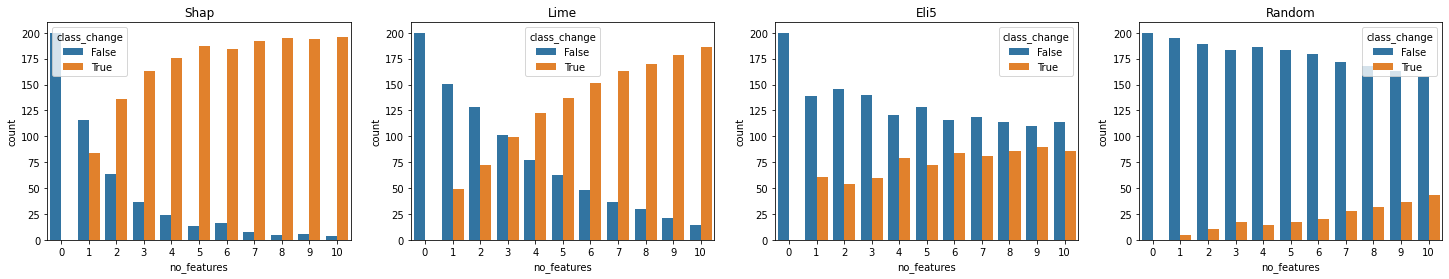

In [22]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == "first") 
#                & (res["original_class"] == 1)
               & (res['strategy'] == 'distribution')]

ax[0]=sns.countplot(x="no_features",data=data[data['explainer'] == 'shap'], hue = 'class_change', ax = ax[0])
ax[0].set_title("Shap")

ax[1]=sns.countplot(x="no_features",data=data[data['explainer'] == 'lime'], hue = 'class_change', ax = ax[1])
ax[1].set_title("Lime")

ax[2]=sns.countplot(x="no_features",data=data[data['explainer'] == 'eli5'], hue = 'class_change', ax = ax[2])
ax[2].set_title("Eli5")

ax[3]=sns.countplot(x="no_features",data=data[data['explainer'] == 'random'], hue = 'class_change', ax = ax[3])
ax[3].set_title("Random")

## G7 Average of confidence level change vs number of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase. This average is on both classes

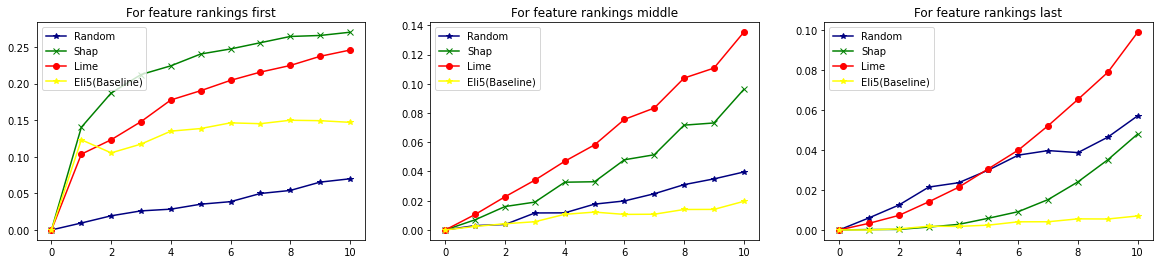

In [23]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

def get_data(explainer, feature_rankings ):
    data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", "first")) ))
ax[0].plot( no_of_features,  get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", feature_rankings) , color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", feature_rankings) , color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings) , color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[0].set_title("For feature rankings first")
ax[0].legend(loc='best')

feature_rankings = "middle"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features,get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[1].set_title("For feature rankings middle")
ax[1].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[2].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[2].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[2].plot( no_of_features,get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[2].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[2].set_title("For feature rankings last")
ax[2].legend(loc='best')

In [24]:
res[(res['nsamples'] == 'auto') ].groupby("no_features")["confidence_diff"].mean() 

no_features
0     0.052163
1     0.067489
2     0.068515
3     0.070678
4     0.073681
5     0.075065
6     0.078103
7     0.077037
8     0.081216
9     0.081965
10    0.085971
Name: confidence_diff, dtype: float64

## G8 Average of confidence level change vs number of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase. This average is per class

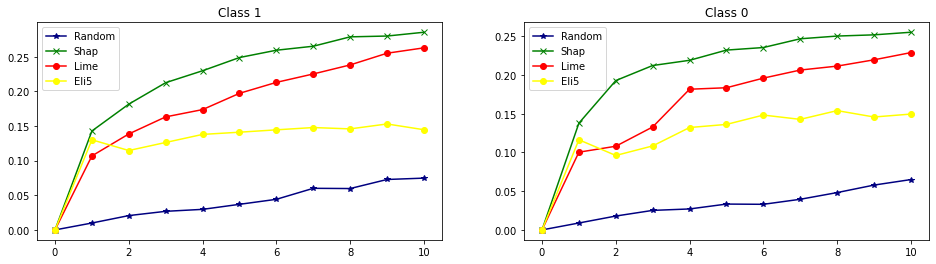

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [25]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, original_class):
    default_data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')]
    return default_data[(default_data['explainer'] == explainer) & (default_data['original_class'] == original_class)].groupby("no_features")["confidence_diff"].mean()

original_class = 1
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(get_data("random", original_class)) ))
ax[0].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Class {}".format(original_class))
ax[0].legend(loc='best')

original_class = 0
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(get_data("random", original_class)) ))
ax[1].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Class {}".format(original_class))
ax[1].legend(loc='best')

## G9 Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1. Interesting to change ((res["original_class"] == 0/1))

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


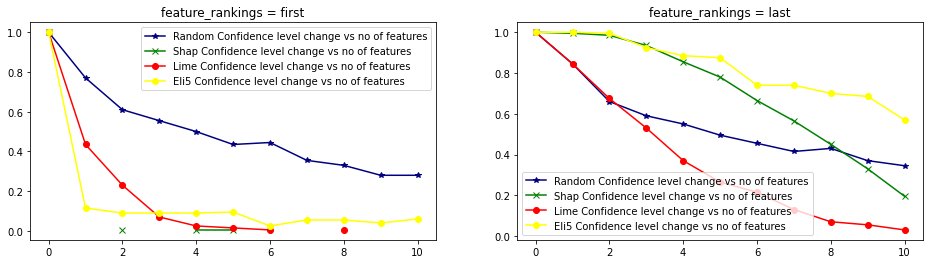

In [26]:
def get_data(explainer, feature_rankings):
    data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == feature_rankings) 
#                & (res["original_class"] == 1)
               & (res['strategy'] == 'distribution')] 
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[0].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[0].set_title("feature_rankings = first")
ax[0].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[1].set_title("feature_rankings = last")
ax[1].legend(loc='best')

## G10 Average time for shap and lime to compute feature importances using nsamples auto (default). Shap is significantly higher. 

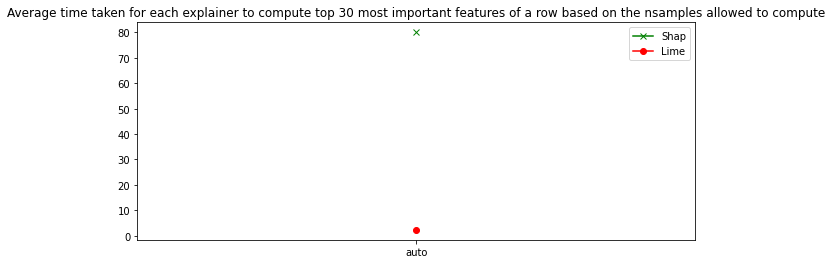

In [27]:
avg_shap = res[(res["no_features"]==0) & (res['explainer'] == 'shap')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'mean')].groupby("nsamples")["time"].mean()
avg_lime = res[(res["no_features"]==0) & (res['explainer'] == 'lime')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'mean')].groupby("nsamples")["time"].mean()

plt.figure(figsize=(10,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_shap)))
# plt.plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
plt.plot( avg_lime.keys(), avg_shap, color='green', marker='x', linestyle='-', label='Shap')
plt.plot( avg_lime.keys(), avg_lime, color='red', marker='o', linestyle='-', label='Lime')
plt.title("Average time taken for each explainer to compute top 30 most important features of a row based on the nsamples allowed to compute")
plt.legend(loc='best')

# Some graphs generated by explainers

## G11 Eli5 This computes the global feature importance - this is not a true eli5 algorithm.

In [28]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():       
    return model
# X_train_unscaled, X_test_unscaled, y_train, y_test
# train_x, val_x, train_y, val_y
my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X_test, y_test)

perm = PermutationImportance(my_model).fit(X_test[0:1000],y_test[0:1000])
eli5.show_weights(perm, feature_names = list(df.drop('loan_repaid', axis=1).columns))

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


32/32 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.8040 - f1: 0.8843


32/32 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8060 - f1: 0.8852


Weight,Feature
0.0840 ± 0.0139,sub_grade
0.0077 ± 0.0023,int_rate
0.0054 ± 0.0037,dti
0.0042 ± 0.0045,term
0.0031 ± 0.0013,total_acc
0.0027 ± 0.0012,home_ownership
0.0021 ± 0.0021,purpose_debt_consolidation
0.0018 ± 0.0010,initial_list_status
0.0017 ± 0.0019,revol_util
0.0016 ± 0.0015,annual_inc


In [29]:
help(PermutationImportance)

Help on class PermutationImportance in module eli5.sklearn.permutation_importance:

class PermutationImportance(sklearn.base.BaseEstimator, sklearn.base.MetaEstimatorMixin)
 |  PermutationImportance(estimator, scoring=None, n_iter=5, random_state=None, cv='prefit', refit=True)
 |  
 |  Meta-estimator which computes ``feature_importances_`` attribute
 |  based on permutation importance (also known as mean score decrease).
 |  
 |  :class:`~PermutationImportance` instance can be used instead of
 |  its wrapped estimator, as it exposes all estimator's common methods like
 |  ``predict``.
 |  
 |  There are 3 main modes of operation:
 |  
 |  1. cv="prefit" (pre-fit estimator is passed). You can call
 |     PermutationImportance.fit either with training data, or
 |     with a held-out dataset (in the latter case ``feature_importances_``
 |     would be importances of features for generalization). After the fitting
 |     ``feature_importances_`` attribute becomes available, but the estimat

## G12 Lime example

In [30]:
row_number=2
columns = list(df.drop('loan_repaid', axis=1).columns)
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, class_names=list(['Charged off', 'Fully paid']), feature_names= list(df.drop('loan_repaid', axis=1).columns))
exp = explainer_lime.explain_instance(X_test[row_number], model.predict, num_features=30, top_labels=30)  
exp.show_in_notebook(show_table=True, show_all=False)
# model.predict()


                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


## G13 Shap example decision plot

In [31]:
# eli5.show_prediction(model, X_test[row_number].reshape(1, X_test.shape[1]))

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


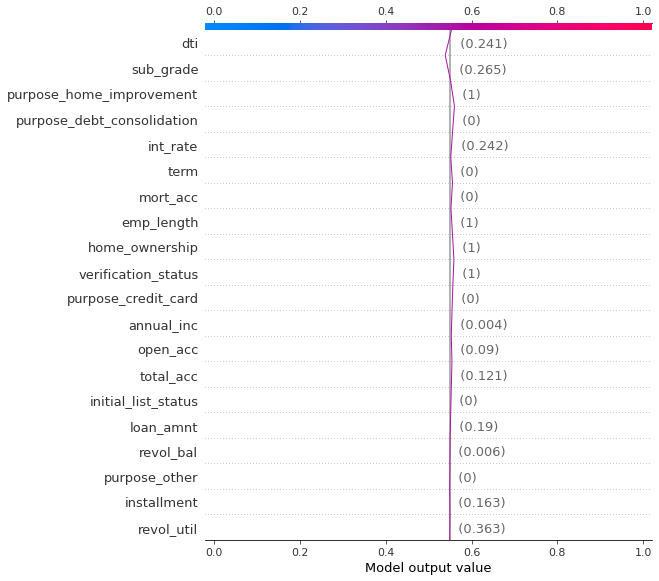

In [32]:
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html -- types of plots available for shap
import shap
def predict_fn(x):
    preds = model.predict(x).reshape(-1, 1)
    p0 = 1 - preds
    return np.hstack((p0, preds))
row_number=2
explainer_shap = shap.KernelExplainer(predict_fn, X_train[0:1000])
shap_values = explainer_shap.shap_values(X_test[row_number].reshape(1, X_test.shape[1]), nsamples="auto", l1_reg="num_features(30)")

shap.decision_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

## G14 Shap example force plot (same as a decision plot)

In [33]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [34]:
explainer_shap.expected_value

array([0.19580238, 0.80419762])

In [35]:
class_avg_1 = [a for a in y_test if a  ==1]
sum(class_avg_1)/len(y_train)
# class_avg_1
model.predict(X_test[row_number].reshape(1, X_test.shape[1]))

array([[0.7862112]], dtype=float32)

## G15 Shap summary plot ( a global feature importance plot - only 10 values are used as it would not complete otherwise)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

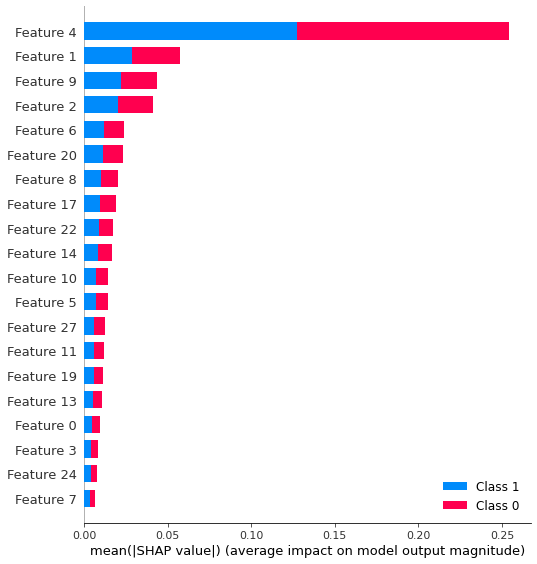

In [36]:
global_shap_values = explainer_shap.shap_values(X_test[0:10])
shap.summary_plot(global_shap_values, X_test[0:10])

In [37]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

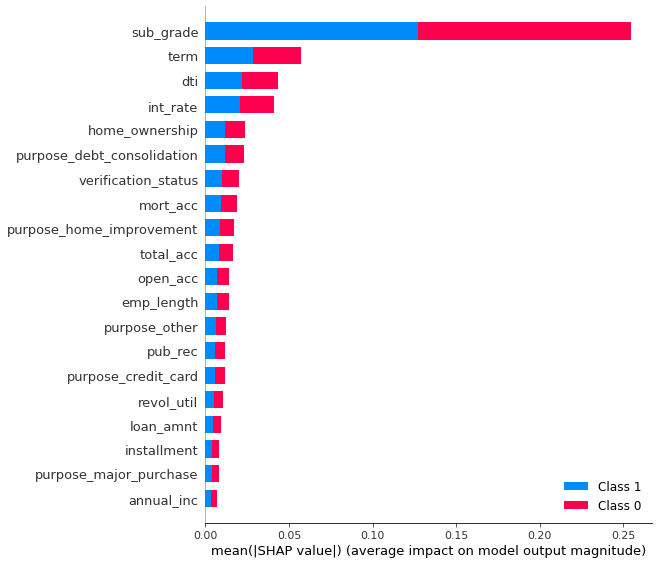

In [38]:
shap.summary_plot(global_shap_values, X_test[0:10], plot_type="bar", feature_names=list(df.drop('loan_repaid', axis=1).columns))

## G16 Tensorboard results - ordereded by ray/tune/keras_info/val_binary_accuracy

In [39]:
%reload_ext tensorboard
%tensorboard --logdir "tune_results/" 

Reusing TensorBoard on port 6006 (pid 18064), started 14:17:47 ago. (Use '!kill 18064' to kill it.)

In [40]:
stop
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))

NameError: name 'stop' is not defined

In [ ]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))